Импортирую pandas и matplotlib

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

Загружаю датасет и вывожу информацию о типе данных каждого столбца

In [37]:
df = pd.read_csv('AAP_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 69.0+ KB


Создаю график распределения цен на акции яблока

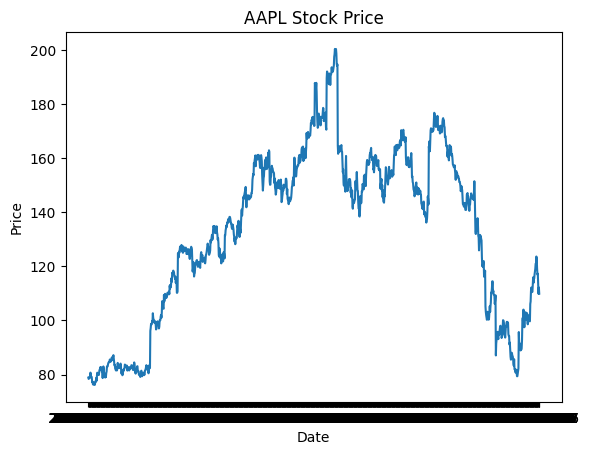

In [29]:
plt.plot(df["date"], df["close"])
plt.title("AAPL Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

Чтобы определить есть ли здесь трендб построил скользящее среднее. Создал график на котором красная линия - это скользящее среднее, которое сглаживает данные и позволяет определить тренд.

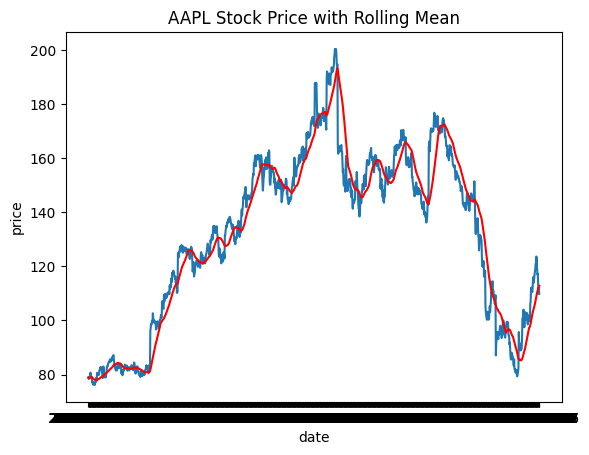

In [30]:
rolling_mean = df["close"].rolling(window = 30, min_periods = 1).mean()
plt.plot(df["date"], df["close"])
plt.plot(df["date"], rolling_mean, color = "red")
plt.title("AAPL Stock Price with Rolling Mean")
plt.xlabel("date")
plt.ylabel("price")
plt.show()

Для определения сезонности, я сделал декомпозицию временных рядов. Создал графики, наблюдаемое, тренд, сезонность и остаточные данные.

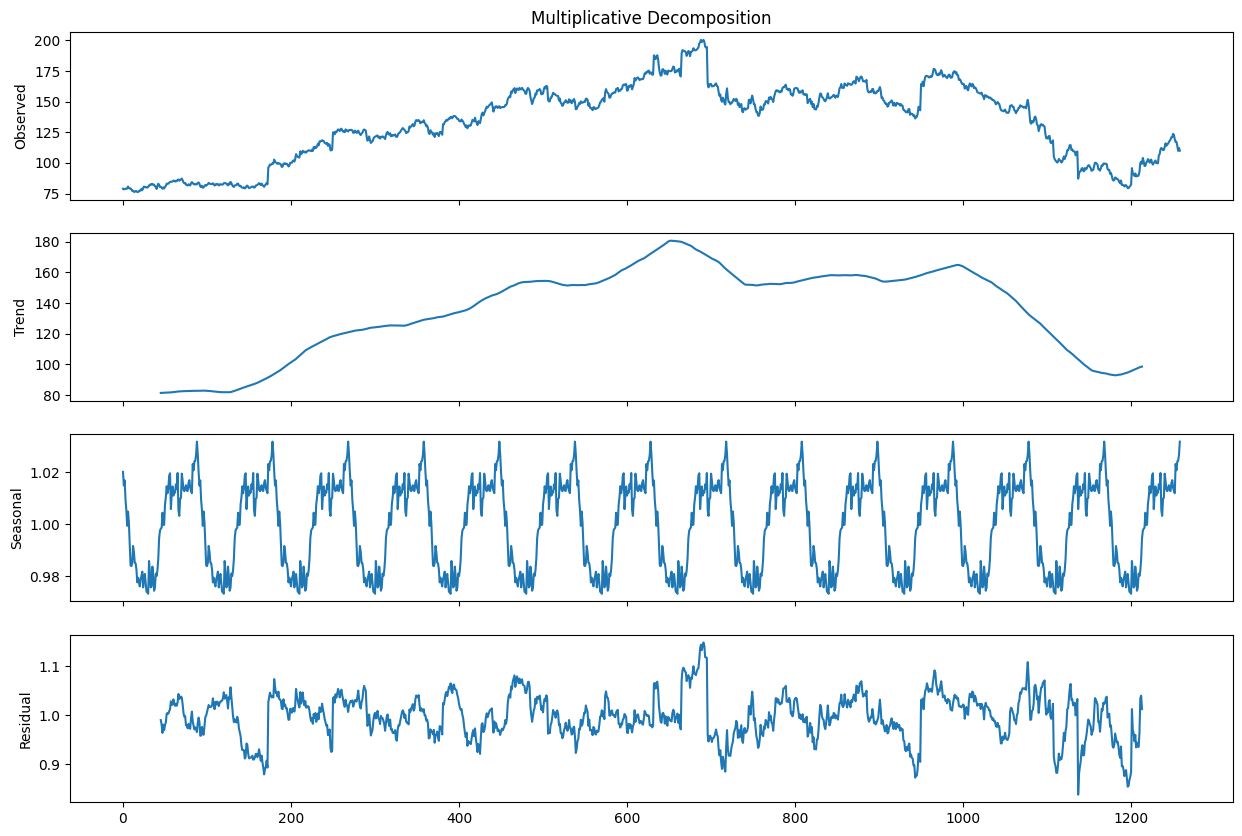

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df["close"], model = "multiplicative", period = 90)

fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize = (15,10))
axes[0].set_title("Multiplicative Decomposition")
result.observed.plot(ax = axes[0], legend = False)
axes[0].set_ylabel("Observed")
result.trend.plot(ax = axes[1], legend = False)
axes[1].set_ylabel("Trend")
result.seasonal.plot(ax = axes[2], legend = False)
axes[2].set_ylabel("Seasonal")
result.resid.plot(ax = axes[3], legend = False)
axes[3].set_ylabel("Residual")
plt.show()

Далее я разделил данные на тренировочные (выбирая для них строки, кроме последних 30) и тестовые (выбирая для последние 30 строк)

In [35]:
train_data = df.iloc[:-30]
test_data = df.iloc[-30:]

Чтобы использовать модель ARIMA, я определил порядок параметров модели: AR(p), I(d), MA(q), где - p это порядок авторегрессии, d - порядок интегрирования и q - порядок скользящего среднего. Для нахождения оптимальных значений модели ARIMA, я сделал поиск по сетке с помощью параметрического перебора. Создал график, на котором показаны исходные данные, тестовые данные и прогнозируемые значения ARIMA.

8
Best model: ARIMA(0, 0, 0) with AIC= 5727.67


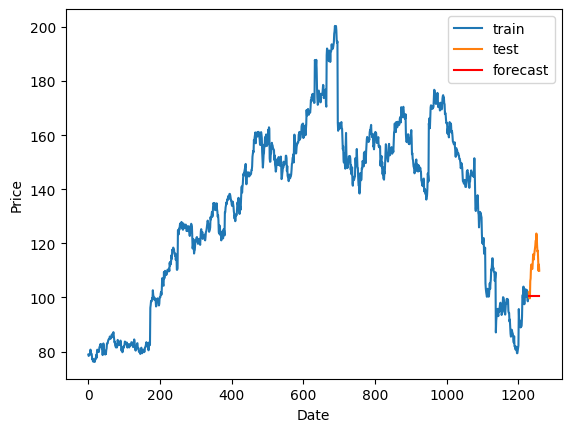

In [54]:
import itertools
import statsmodels.api as sm
import numpy as np

parameters = itertools.product(range(0,2), range(0,2), range(0,2))
parameters_list = list(parameters)
print(len(parameters_list))

def optimize_ARIMA(parameters_list, d, test_data):
    results = []
    best_aic = float('inf')
    
    for param in parameters_list:
        try:
            model = sm.tsa.ARIMA(train_data["close"], order=(param[0], d, param[2])).fit()
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    results_table = pd.DataFrame(results)
    results_table.columns = ["parameters", "aic"]
    results_table = results_table.sort_values(by="aic", ascending=True).reset_index(drop=True)
    
    print(f"Best model: ARIMA{best_param} with AIC= {best_aic:.2f}")
    
    model = sm.tsa.ARIMA(train_data["close"], order=(best_param[0], d, best_param[2])).fit()
    forecast = model.forecast(steps=len(test_data))
    
    return forecast

forecast_ARIMA = optimize_ARIMA(parameters_list, 1, test_data)
forecast_ARIMA.index = test_data.index
plt.plot(train_data["close"])
plt.plot(test_data["close"])
plt.plot(forecast_ARIMA, color="red")
plt.legend(["train", "test", "forecast"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

Для того чтобы использовать модель Хольта-Винтерса я определил порядок сезонности. Создал график, на котором показаны исходные данные, тестовые данные и прогнозируемые значения Хольта-Винтерса.

<ipython-input-58-e9acf612c08a>:4: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train_data["close"], seasonal_periods=7, trend="add", seasonal="add", damped=True)


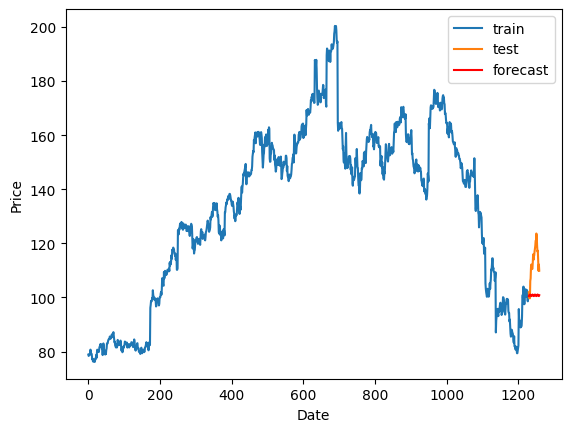

In [58]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def optimize_HoltWinter(train_data, test_data):
  model = ExponentialSmoothing(train_data["close"], seasonal_periods=7, trend="add", seasonal="add", damped=True)
  model_fit = model.fit()
  forecast = model_fit.forecast(len(test_data))
    
  return forecast

forecast_HoltWinter = optimize_HoltWinter(train_data, test_data)
forecast_HoltWinter.index = test_data.index
plt.plot(train_data["close"])
plt.plot(test_data["close"])
plt.plot(forecast_HoltWinter, color="red")
plt.legend(["train", "test", "forecast"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

Для оценки качества, я использовал метрики MAE и MAPE

In [61]:
from sklearn.metrics import mean_absolute_error

mae_ARIMA = mean_absolute_error(test_data["close"], forecast_ARIMA)
mape_ARIMA = np.mean(np.abs((test_data["close"] - forecast_ARIMA) / test_data["close"])) * 100
print("ARIMA")
print(f"MAE: {mae_ARIMA:.2f}")
print(f"MAPE: {mape_ARIMA:.2f}%")

ARIMA
MAE: 12.47
MAPE: 10.76%


In [63]:
mae_HoltWinter = mean_absolute_error(test_data["close"], forecast_HoltWinter)
mape_HoltWinter = np.mean(np.abs((test_data["close"] - forecast_HoltWinter) / test_data["close"])) * 100
print("Holt Winter")
print(f"MAE: {mae_HoltWinter:.2f}")
print(f"MAPE: {mape_HoltWinter:.2f}%")

Holt Winter
MAE: 12.30
MAPE: 10.62%
